In [72]:
import numpy as np
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from functions import set_seed, train, evaluate_nn, Config
from models import MNL_Choice, SCL_Choice, GNNChoiceModel, MLP_Choice
from data_process import load_data, spatial_choice_dataset_interact
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
from matplotlib import cm

comm, hh, edge_index, distance_to_work = load_data()

comm_features = [
    "pop_density",
    "white_prop",
    "black_prop",
    "single_res",
    "multi_res",
    "office",
    # "retail",
    "land_mix",
    "transit_a_scaled",
    "med_house_age_scaled",
    "med_value_scaled",
    "h_units_scaled",
    "median_inc_scaled",
]

hh_features = ["hh_income_scaled", "race_white", "race_black"]


In [73]:
# Set the configurations
device = torch.device("cpu")
config = Config()
config.bs = 32
config.num_hidden = 64
config.dropout = 0.05
config.optimizer = "adam"  # one of [adam, sgd]
config.lr = 0.01
config.lr_scheduler = "one_cycle"  # one of [step, one_cycle, exp, none]
config.n_epoch = 20
config.model = "GAT"  # GAT, GCN, or MPNet (Message Passing Network)
config.aggr = "lse"  # Aggregation method for MPNet, 'add', 'mean', 'max', 'lse', for other models it is not used
config.heads = 4  # Number of attention heads for GAT
config.mode = "disabled"  # online or disabled for wandb logging
config.residual = True  # Whether to use residual connections in GNN
config.seed = 100
config.n_layer = 2  # Number of layers for GNN
config.use_edge_info = False  # Whether to use edge features in GNN
config.edge_dim = None  # Edge features, set to None if not used

if config.use_edge_info and config.model == "GAT":
    config.edge_dim = 1  # Edge features, set to None if not used

my_dataset = spatial_choice_dataset_interact

i = 1
test_idx = np.arange(i, len(hh), 10)
train_idx = np.setdiff1d(np.arange(len(hh)), test_idx)
train_dataset = my_dataset(
    comm,
    hh.loc[train_idx, :],
    distance_to_work[train_idx],
    comm_features,
    hh_features,
)
test_dataset = my_dataset(
    comm,
    hh.loc[test_idx, :],
    distance_to_work[test_idx],
    comm_features,
    hh_features,
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=config.bs, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=len(test_dataset), shuffle=False
)
criterion = nn.NLLLoss()

# Train the GNN choice model
set_seed(config.seed)
model = GNNChoiceModel(
    model_name=config.model,
    num_features=train_dataset[0][0].shape[-1],
    num_hidden=config.num_hidden,
    edge_index=edge_index,
    dropout=config.dropout,
    heads=config.heads,
    residual=config.residual,
    n_layer=config.n_layer,
    edge_dim=config.edge_dim,
).to(device)

set_seed(config.seed)
model = train(
    model,
    criterion,
    train_loader,
    None,
    test_loader,
    config,
    device,
    verbose=True,
    comm=comm,
)


Epoch [0/20], Loss: 3.7750	 total time: 3.76
Epoch [1/20], Loss: 3.5622	 total time: 7.59
Epoch [2/20], Loss: 3.5356	 total time: 11.37
Epoch [3/20], Loss: 3.5171	 total time: 15.08
Epoch [4/20], Loss: 3.4897	 total time: 18.62
Epoch [5/20], Loss: 3.4708	 total time: 22.20
Epoch [6/20], Loss: 3.4565	 total time: 25.74
Epoch [7/20], Loss: 3.4543	 total time: 29.30
Epoch [8/20], Loss: 3.4408	 total time: 32.84
Epoch [9/20], Loss: 3.4381	 total time: 36.46
Epoch [10/20], Loss: 3.4196	 total time: 39.99
Epoch [11/20], Loss: 3.4163	 total time: 43.60
Epoch [12/20], Loss: 3.4096	 total time: 47.15
Epoch [13/20], Loss: 3.3953	 total time: 50.71
Epoch [14/20], Loss: 3.3857	 total time: 54.30
Epoch [15/20], Loss: 3.3766	 total time: 57.85
Epoch [16/20], Loss: 3.3677	 total time: 61.44
Epoch [17/20], Loss: 3.3464	 total time: 65.00
Epoch [18/20], Loss: 3.3436	 total time: 68.62
Epoch [19/20], Loss: 3.3292	 total time: 72.27
Train results: {'train_f1': 0.07347511087158982, 'train_accuracy': np.fl

In [84]:
# Get the attention weights from the first GAT layer
input, target = test_dataset[10]
model.eval()
with torch.no_grad():
    ii = model.in_layer(input)
    out, weights = model.gnn.convs[0].forward(
        ii, model.edge_index, return_attention_weights=True
    )

print(weights[0].shape)
print(weights[1].shape)

torch.Size([2, 471])
torch.Size([471, 4])


## Plot the directed attention weights on the map

In [273]:
from matplotlib.patches import FancyArrowPatch
from matplotlib.patches import ArrowStyle
def map_weight_to_color(weights, head=0, fig=None, ax=None, vmax=0.8, colorbar=True):
    index = weights[0].detach().numpy()
    edge_weights = (
        weights[1][:, head].detach().numpy()
    )  # Get the attention weights for edges

    norm = Normalize(vmin=edge_weights.min(), vmax=vmax)
    cmap = cm.Blues

    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(5, 8))
    comm.plot(ax=ax, color="white", edgecolor="black", linewidth=0.7, alpha=0.5)
    ax.margins(0)
    for i in range(index.shape[1]):
        weight = edge_weights[i]
        color = cmap(norm(weight))
        start_node = index[0][i]
        end_node = index[1][i]
        # Plot directed edges
        if start_node != end_node:
            start_x = comm.loc[start_node, "geometry"].centroid.x
            start_y = comm.loc[start_node, "geometry"].centroid.y
            end_x = comm.loc[end_node, "geometry"].centroid.x
            end_y = comm.loc[end_node, "geometry"].centroid.y
            start_x = end_x - (end_x - start_x) * 0.5
            start_y = end_y - (end_y - start_y) * 0.5

            # Plot arrows for directed edges
            arrow = FancyArrowPatch(
                (start_x, start_y),
                (end_x, end_y),
                arrowstyle=ArrowStyle(
                    "-|>", head_length=0.3, head_width=0.1, widthB=0.08
                ),  # tail width
                color=color,
                linewidth=1,
                mutation_scale=5,  # arrow head size
                shrinkA=0.0,  # start gap
                shrinkB=0.5,  # end gap
                edgecolor=None,
            )
            ax.add_patch(arrow)

            # Plot lines
            # ax.plot(
            #     (
            #         start_x,
            #         end_x,
            #     ),  # x-coordinates
            #     (
            #         start_y,
            #         end_y,
            #     ),  # y-coordinates
            #     "-",
            #     color=color,
            #     linewidth=1,
            # )
        # Plot nodes
        else:
            ax.plot(
                comm.loc[start_node, "geometry"].centroid.x,
                comm.loc[start_node, "geometry"].centroid.y,
                "o",
                color=color,
                markersize=3,
                markeredgecolor="black",
                markeredgewidth=0.2,
            )
    # Remove all axes
    ax.axis("off")
    # ax.legend(frameon=False, loc="center left")
    if colorbar:
        # Create colorbar with specific position and size
        cax = inset_axes(
            ax,
            width="3%",  # Width of colorbar as a percentage of ax width
            height="30%",  # Height of colorbar as a percentage of ax height
            loc="lower left",  # Position of the colorbar within ax
            borderpad=4,  # Padding around colorbar
        )

        # Create colorbar with the inset axes
        norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
        cbar = fig.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap="Blues"), cax=cax, orientation="vertical",
            ax=ax
        )
        cbar.set_label("Attention weights", fontsize=10)  # Optional label for the colorbar
        cbar.ax.tick_params(labelsize=8)  # Adjust colorbar tick font size
        cbar.ax.yaxis.set_ticks_position("left")
        cbar.ax.yaxis.set_label_position("left")

Text(1109500.5500807837, 1889515.7512119892, 'Austin')

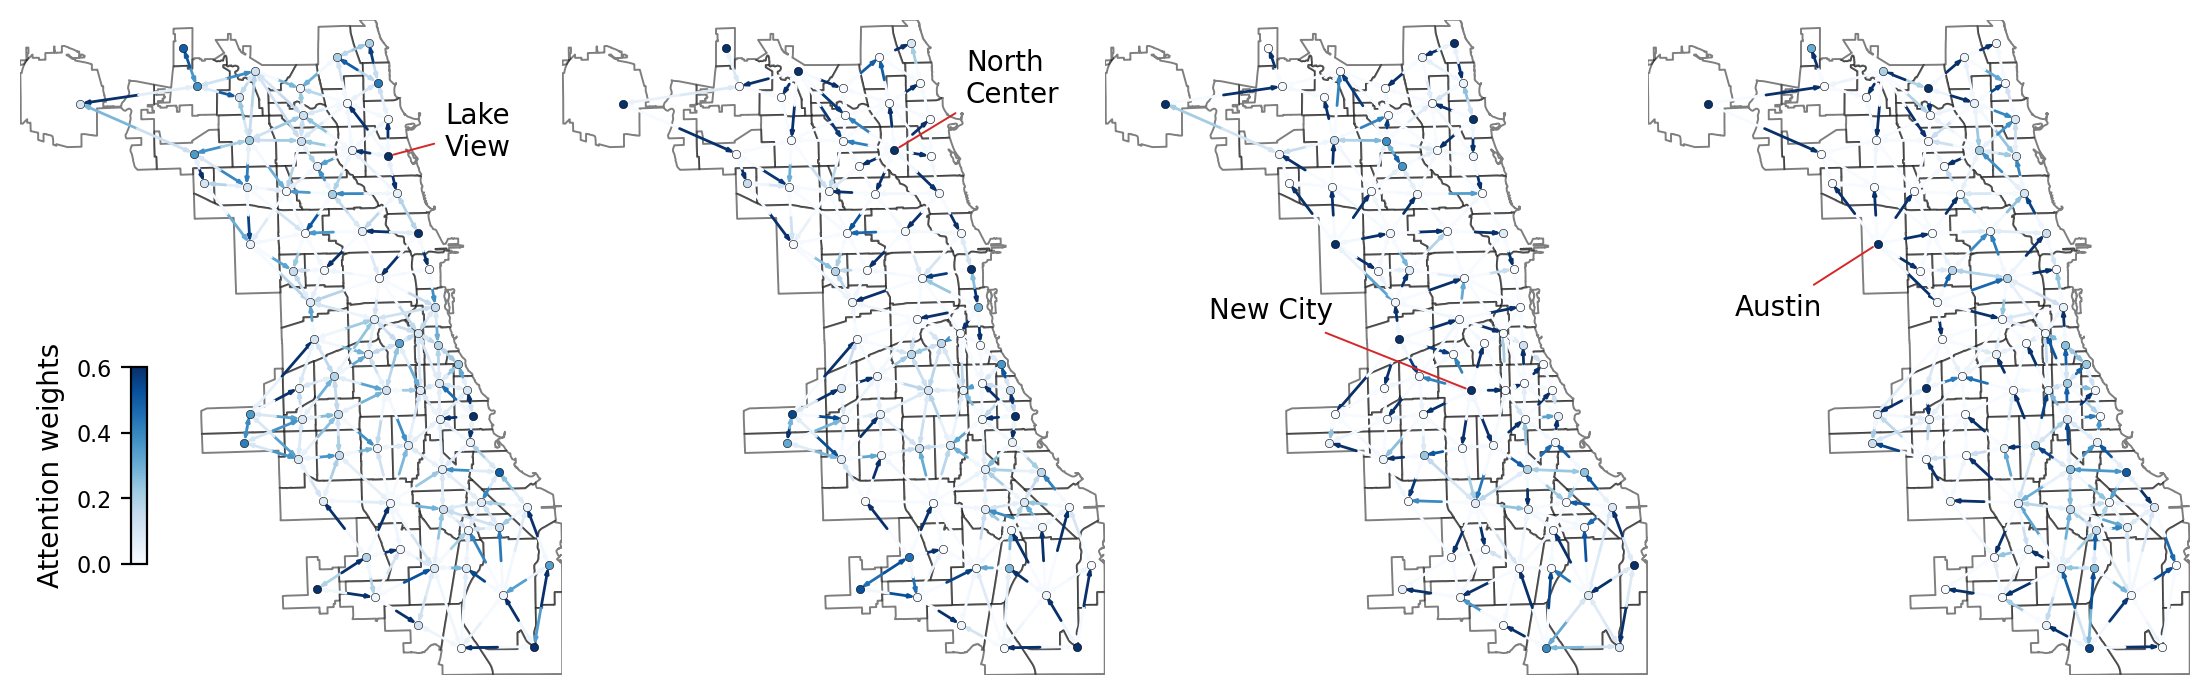

In [274]:
%config InlineBackend.figure_format = 'retina'
fig, axes = plt.subplots(
    figsize=(14, 8),
    nrows=1,
    ncols=4,
    gridspec_kw={"wspace": 0.0},
)
vmax = 0.6
map_weight_to_color(weights, head=0, fig=fig, ax=axes[0], vmax=vmax)
map_weight_to_color(weights, head=1, fig=fig, ax=axes[1], vmax=vmax, colorbar=False)
map_weight_to_color(weights, head=2, fig=fig, ax=axes[2], vmax=vmax, colorbar=False)
map_weight_to_color(weights, head=3, fig=fig, ax=axes[3], vmax=vmax, colorbar=False)

# Make some notations
x = comm.loc[comm.community == "LAKE VIEW", "geometry"].centroid.x.iloc[0]
y = comm.loc[comm.community == "LAKE VIEW", "geometry"].centroid.y.iloc[0]
axes[0].annotate(
    "Lake\nView",
    xy=(x, y),
    xytext=(x + 12000, y),
    arrowprops=dict(
        arrowstyle="-",
        color="C3",
        linewidth=0.7,
        # shrinkA=0,
        # shrinkB=0,
    ),
)


x = comm.loc[comm.community == "NORTH CENTER", "geometry"].centroid.x.iloc[0]
y = comm.loc[comm.community == "NORTH CENTER", "geometry"].centroid.y.iloc[0]
axes[1].annotate(
    "North\nCenter",
    xy=(x, y),
    xytext=(x + 15000, y + 10000),
    arrowprops=dict(
        arrowstyle="-",
        color="C3",
        linewidth=0.7,
        # connectionstyle="angle,angleA=0,angleB=90",  # horizontal at text
        # shrinkA=0,
        # shrinkB=0,
    ),
)

# Make some notations
x = comm.loc[comm.community == "NEW CITY", "geometry"].centroid.x.iloc[0]
y = comm.loc[comm.community == "NEW CITY", "geometry"].centroid.y.iloc[0]
axes[2].annotate(
    "New City",
    xy=(x, y),
    xytext=(x - 55000, y + 15000),
    arrowprops=dict(
        arrowstyle="-",
        color="C3",
        linewidth=0.7,
        # connectionstyle="angle,angleA=180, angleB=90",  # horizontal at text
    ),
)

# Make some notations
x = comm.loc[comm.community == "AUSTIN", "geometry"].centroid.x.iloc[0]
y = comm.loc[comm.community == "AUSTIN", "geometry"].centroid.y.iloc[0]
axes[3].annotate(
    "Austin",
    xy=(x, y),
    xytext=(x - 30000, y - 15000),
    arrowprops=dict(arrowstyle="-", color="C3", linewidth=0.7,
                    # connectionstyle="angle,angleA=180, angleB=90",  # horizontal at text
                    ),
)

In [275]:
fig.savefig("gat_attention_heads.pdf", dpi=300)